# Deep GPs

Here we are working with a 2-layer deep GP model where the input layer has a kernel that takes into account mixed input spaces.

In [7]:
from torch.utils.data import TensorDataset, DataLoader
import torch

# Generate some sample data
n = 800 # Number of data points
torch.manual_seed(0)

# Continuous feature
x_cont = torch.randn(n, 1)

# Discrete feature (e.g., 0 or 1)
x_disc = torch.randint(0, 2, (n, 1)).float()

# Output target
y = x_cont * 2 + x_disc * 3 + torch.randn(n, 1) * 0.1

# Combine features
x = torch.cat([x_cont, x_disc], dim=1)

print(x.shape)
print(y.shape)

# Create a DataLoader
dataset = TensorDataset(x, y)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


torch.Size([800, 2])
torch.Size([800, 1])


In [2]:
from gp.mixeddeepgp import BotorchDeepGPMixed

# Define model
cat_dims = [1]  # Index of the categorical feature

model = BotorchDeepGPMixed(
    train_x_shape=x.shape,
    cat_dims=cat_dims,
    num_hidden_dims=15,
    num_inducing_points=128
)

In [8]:
import gpytorch
from gpytorch.mlls import VariationalELBO, DeepApproximateMLL

# Define likelihood and mll
likelihood = model.likelihood
mll = DeepApproximateMLL(VariationalELBO(likelihood, model, num_data=len(dataset)))

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
model.train()
likelihood.train()

num_epochs = 15
for epoch in range(num_epochs):
    for x_batch, y_batch in train_loader:
        with gpytorch.settings.num_likelihood_samples(16):
            optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch)
            loss.backward()
            optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

Epoch 1/100, Loss: 5.0438063369421045
Epoch 11/100, Loss: 2.7917821923637183
Epoch 21/100, Loss: 2.335837469040104
Epoch 31/100, Loss: 2.778059201957322
Epoch 41/100, Loss: 2.5076440672682616
Epoch 51/100, Loss: 2.549867115474833
Epoch 61/100, Loss: 2.3292230232326006
Epoch 71/100, Loss: 2.2865034585239146
Epoch 81/100, Loss: 2.229555349545582
Epoch 91/100, Loss: 2.1854131471837253


In [15]:
model.eval()
likelihood.eval()

# Create a test dataset
x_test_cont = torch.randn(10, 1)
x_test_disc = torch.randint(0, 2, (10, 1)).float()
x_test = torch.cat([x_test_cont, x_test_disc], dim=1)

# Get the posterior predictions
posterior = model.posterior(x_test)
print(model.predict(DataLoader(TensorDataset(x, x))))
mean = posterior.mean
variance = posterior.variance

print("Mean predictions:", mean)
print("Variance predictions:", variance)

(tensor([[1.6539, 1.6539, 1.6539,  ..., 1.6539, 1.6539, 1.6539],
        [1.6539, 1.6539, 1.6539,  ..., 1.6539, 1.6539, 1.6539],
        [1.6539, 1.6539, 1.6539,  ..., 1.6539, 1.6539, 1.6539],
        ...,
        [1.6539, 1.6539, 1.6539,  ..., 1.6539, 1.6539, 1.6539],
        [1.6539, 1.6539, 1.6539,  ..., 1.6539, 1.6539, 1.6539],
        [1.6539, 1.6539, 1.6539,  ..., 1.6539, 1.6539, 1.6539]],
       dtype=torch.float64), tensor([[6.1697, 6.1697, 6.1697,  ..., 6.1697, 6.1697, 6.1697],
        [6.1697, 6.1697, 6.1697,  ..., 6.1697, 6.1697, 6.1697],
        [6.1697, 6.1697, 6.1697,  ..., 6.1697, 6.1697, 6.1697],
        ...,
        [6.1697, 6.1697, 6.1697,  ..., 6.1697, 6.1697, 6.1697],
        [6.1697, 6.1697, 6.1697,  ..., 6.1697, 6.1697, 6.1697],
        [6.1697, 6.1697, 6.1697,  ..., 6.1697, 6.1697, 6.1697]],
       dtype=torch.float64), tensor([[-2.4550, -1.8634, -2.4670,  ..., -1.8634, -1.8912, -2.0505],
        [-2.4550, -1.8634, -2.4670,  ..., -1.8634, -1.8912, -2.0505],
     

In [13]:
from matplotlib import pyplot as plt


def plot_predictions(model, x_test, y_test=None):
    model.eval()

    # Get the posterior predictions
    posterior = model.posterior(x_test)
    mean = posterior.mean.detach().numpy()
    variance = posterior.variance.detach().numpy()
    lower = mean - 1.96 * variance ** 0.5
    upper = mean + 1.96 * variance ** 0.5

    plt.figure(figsize=(10, 6))

    # Plot the predictions
    plt.plot(x_test, mean, 'b', label='Predicted Mean')
    plt.fill_between(range(len(mean)), lower, upper, alpha=0.3, label='Confidence Interval')

    if y_test is not None:
        y_test = y_test.numpy()
        plt.plot(y_test, 'r', label='Ground Truth')

    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.title('Predictions vs Ground Truth')
    plt.show()

ValueError: 'x' is not 1-dimensional

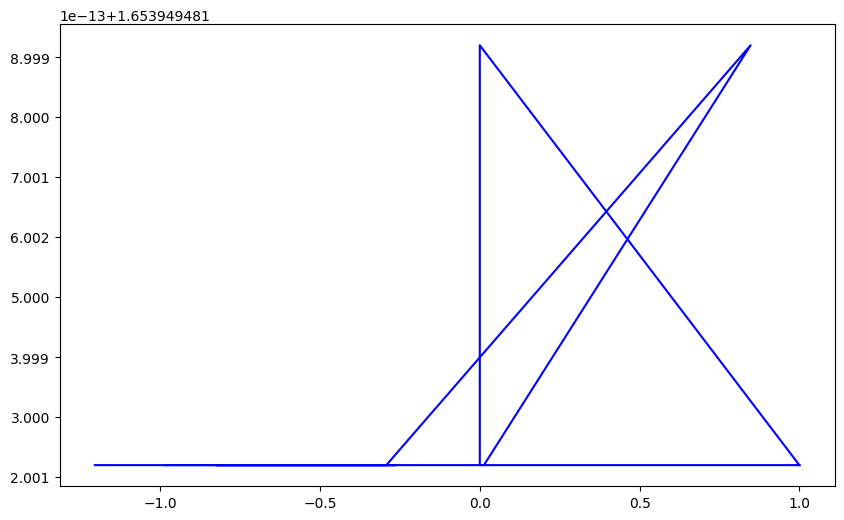

In [14]:
plot_predictions(model, x_test)